In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
import os
import librosa
import IPython
import glob

from tqdm import tqdm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from visualkeras import layered_view
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Part 1: Data visualization

### 1.1 Csv file

In [2]:
# Read the data
data = pd.read_csv("archive/Data/features_30_sec.csv")

In [3]:
# Print the genres of music
genres = 'archive/Data'
print(list(os.listdir(f'{genres}/genres_original/')))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [4]:
# Print the data outline
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [6]:
# Print the data shape
data.shape

(1000, 60)

In [7]:
# Print the type of data for the feature
data.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [8]:
# Remove unnecessary feature data
data = data.drop(labels='filename', axis=1)
data = data.drop(labels='length', axis=1)

### 1.2 Wav files (First track in blues)

In [9]:
audio = "archive/Data/genres_original/blues/blues.00000.wav"
#Load & decode the audio as a time series, where sr represents the sampling rate
wave , sr = librosa.load(audio)
print(type(data), type(sr))

<class 'pandas.core.frame.DataFrame'> <class 'int'>


In [10]:
# Print file information
print(librosa.load(audio, sr=sr))
print('data shape:', np.shape(wave))
print('Sample rate:', sr)
print('Len of audio', 661797/22050)

(array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
       -0.06106567, -0.06417847], dtype=float32), 22050)
data shape: (661794,)
Sample rate: 22050
Len of audio 30.0134693877551


In [11]:
# Play the audio
IPython.display.Audio(wave, rate=sr)

#### Waveform and spectrogram

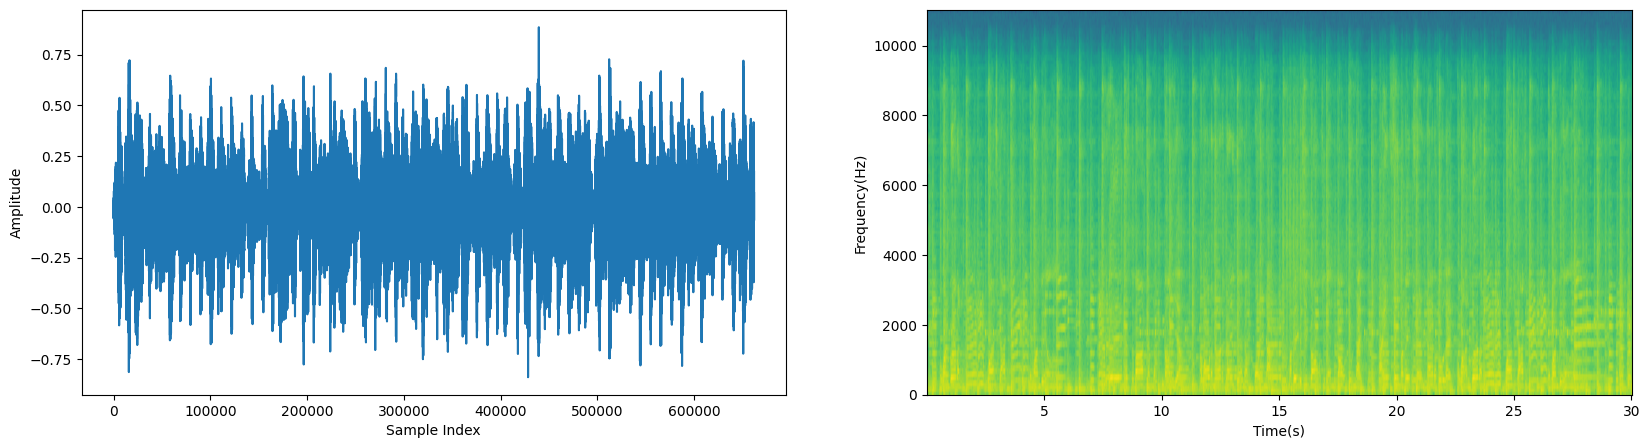

In [12]:
# Print the waveform and spectrogram
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(wave)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.specgram(wave, Fs=sr)
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')

plt.show()

#### Fourier transform

(1025, 1293)


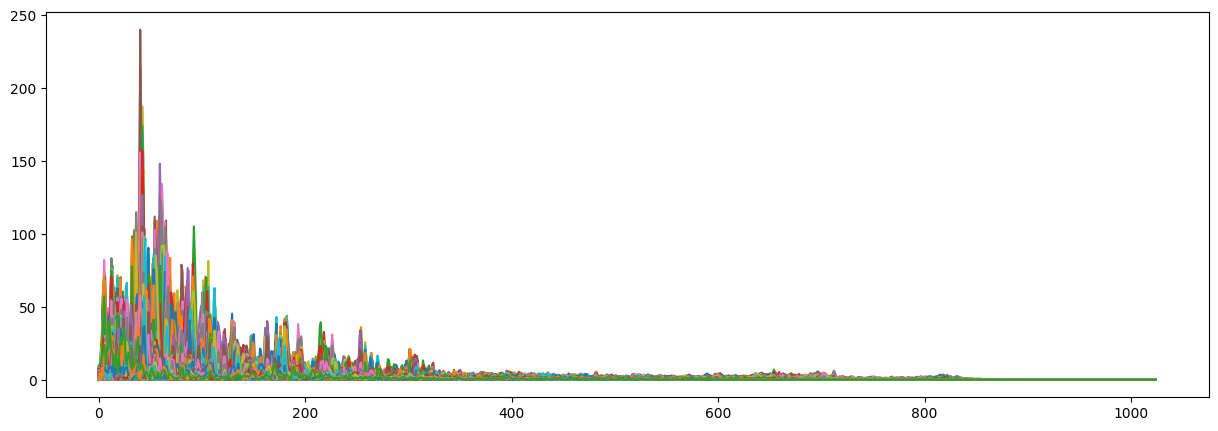

In [13]:
ws_fft = 2048 # window size
dt = np.abs(librosa.stft(wave, n_fft=ws_fft))
print(np.shape(dt))
plt.figure(figsize=(15,5))
plt.plot(dt)
plt.show()

#### Zero cross rate

In [14]:
# Print the total zero crossings
zero_cross = librosa.zero_crossings(wave, pad=False)
print(sum(zero_cross))

55031


## Part 2: Explore Feature

### 2.1 Explore feature correlations and the tempo distribution of different genres

In [15]:
# Use feature_30_sec.csv to explore the features
data2 = pd.read_csv("archive/Data/features_30_sec.csv")
data2.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


#### Correlation heatmap for feature means

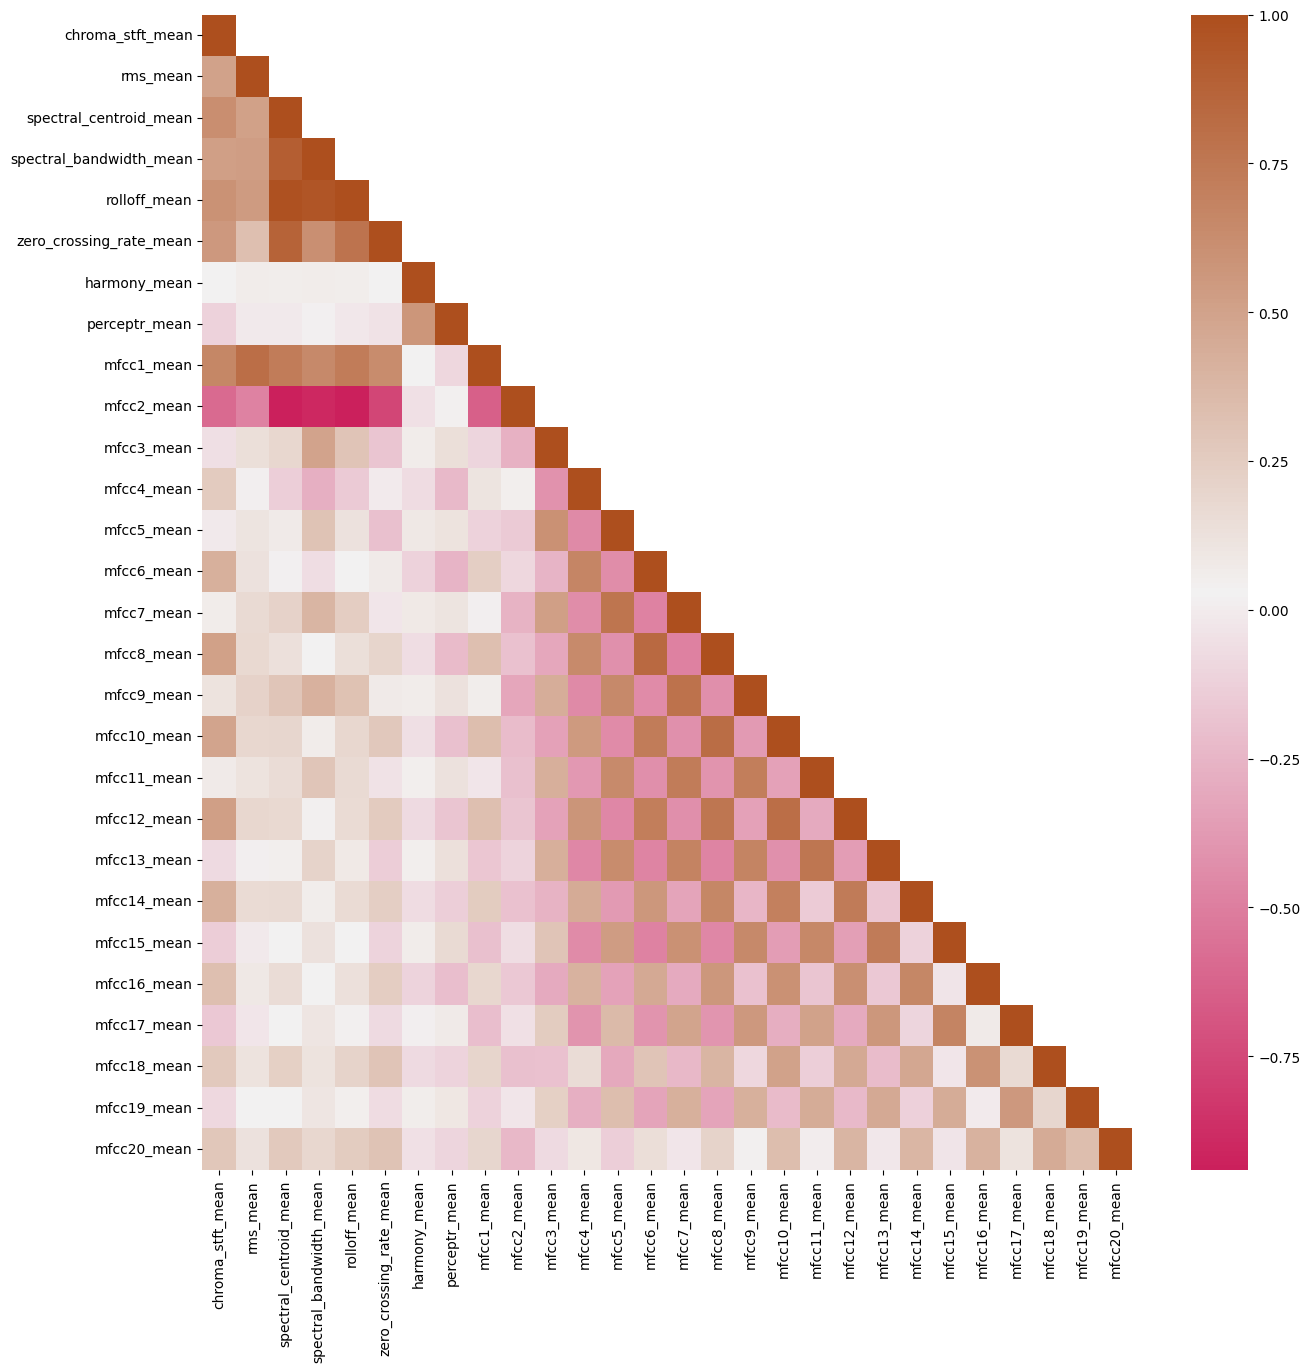

In [80]:
# Print a correlation heatmap (masked up triangle)
cols = [col for col in data2.columns if 'mean' in col]
corr = data2[cols].corr()

cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

mask = np.zeros_like(corr)
for i in range(1,len(mask)):
  for j in range(0,i):
    mask[j][i] = True

plt.figure(figsize=(15, 15))
sns.heatmap(corr, cmap=cmap, mask=mask)

plt.show()

#### Box Plot for Genres Distributions

C:\Users\Eazy\AppData\Local\Temp\ipykernel_32632\1650558583.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl')


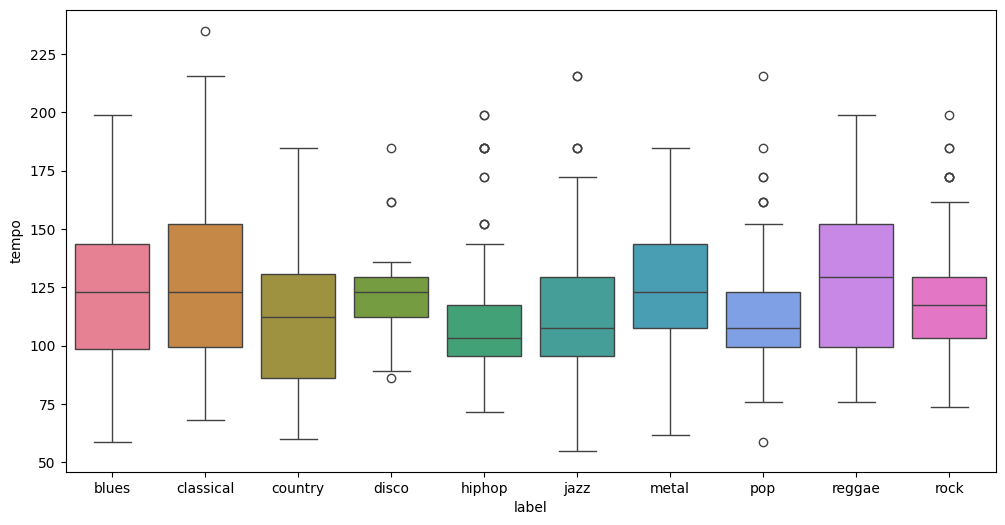

In [17]:
# Print a box plot
x = data2[["label", "tempo"]]

f, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl')
plt.show()

### 2.2 Principal Component Analysis

#### Normalization

In [18]:
data2 = data2.iloc[0:, 1:]
# Get labels
y = data2['label']
# Get features without label
x = data2.loc[:, data2.columns != 'label']

cols = x.columns
# Use min max scaler
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(x)
x = pd.DataFrame(scaled, columns=cols)
x


,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.113487,0.362279,0.695468,0.318188,0.101983,0.314117,0.040233,0.422879,0.109789,0.385532,...,0.564186,0.112704,0.541287,0.057615,0.422444,0.082450,0.487950,0.109503,0.599189,0.078255
1,0.113487,0.343622,0.793392,0.230894,0.085580,0.248405,0.121475,0.436889,0.296867,0.353329,...,0.570198,0.120353,0.574685,0.118286,0.448184,0.102997,0.548800,0.099081,0.579640,0.075947
2,0.113487,0.389832,0.640692,0.433652,0.099064,0.254261,0.049046,0.325334,0.095712,0.289224,...,0.622467,0.081898,0.331003,0.085962,0.370988,0.116420,0.453724,0.087317,0.501381,0.045405
3,0.113487,0.473508,0.777954,0.345856,0.229160,0.129376,0.058253,0.267404,0.227566,0.181068,...,0.565151,0.091876,0.484549,0.092509,0.460684,0.068975,0.538690,0.062612,0.468060,0.048168
4,0.113487,0.277759,0.681062,0.219641,0.083075,0.327270,0.110761,0.325514,0.113536,0.357017,...,0.383289,0.200462,0.410225,0.156424,0.403875,0.120300,0.424652,0.130173,0.233047,0.094836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.113487,0.366294,0.565355,0.188974,0.012317,0.372066,0.090548,0.462737,0.113776,0.442001,...,0.599764,0.093498,0.137363,0.070955,0.528217,0.067274,0.355114,0.108986,0.530772,0.084307
996,0.113487,0.461109,0.480368,0.181264,0.021099,0.371728,0.057513,0.448340,0.104735,0.428856,...,0.666628,0.064317,0.222386,0.064937,0.506174,0.052253,0.332575,0.067713,0.485401,0.047815
997,0.113487,0.529141,0.483246,0.194487,0.011492,0.390015,0.073870,0.394101,0.093465,0.413981,...,0.601418,0.063653,0.152848,0.057215,0.563199,0.064824,0.178146,0.076420,0.504920,0.043984
998,0.113487,0.387488,0.738721,0.200112,0.043603,0.214389,0.076729,0.352424,0.143718,0.285865,...,0.441895,0.096819,0.446369,0.075619,0.494291,0.059564,0.405462,0.088864,0.462871,0.066938


#### PCA

In [19]:
# Use PCA to 
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
# Create a new data form to save data after pca
pca_data = pd.DataFrame(data = principal_components, columns=['Pc1', 'Pc2'])

# Combined data
final_data = pd.concat([pca_data, y], axis = 1)

pca.explained_variance_ratio_

array([0.2439355 , 0.21781804])

#### Scatterplot

<Axes: xlabel='Pc1', ylabel='Pc2'>

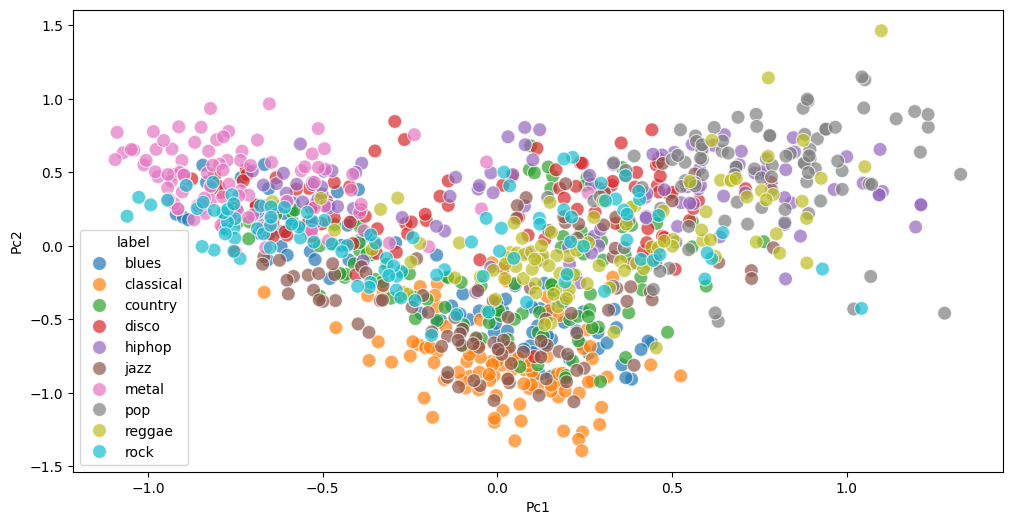

In [20]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Pc1', y='Pc2', data=final_data, hue='label', alpha=0.7,s=100)

## Part 3: Data preprocessing

### 3.1 Data for CNN (From wav files)

In [21]:
# Load the vggish model.
vggish = hub.load('https://kaggle.com/models/google/vggish/frameworks/TensorFlow2/variations/vggish/versions/1')

In [22]:
# Function to extract audio features using VGGish
def extractFeatures(audioFile):
    try:
        # Loading audio file
        waveform, sr = librosa.load(audioFile)
        
        # Trimming silence
        waveform, _ = librosa.effects.trim(waveform)
        
        # Extracting features using VGGish
        return vggish(waveform).numpy()
    except:
        return None

In [23]:
# Root directory containing the audio files
root = 'archive\Data\genres_original'
data = []

# Iterating through the folders and files to extract features
for folder in os.listdir(root):
    folderPath = os.path.join(root, folder)
    
    for file in tqdm(os.listdir(folderPath), desc = f'Processing folder {folder}'):
        filePath = os.path.join(folderPath, file)
        features = extractFeatures(filePath)
        
        if features is not None:
            data.append([features, folder])

Processing folder jazz:  54%|█████▍    | 54/100 [00:10<00:09,  5.01it/s]C:\Users\Eazy\AppData\Local\Temp\ipykernel_32632\3964492277.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(audioFile)
d:\Python\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing folder rock: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


In [24]:
data = pd.DataFrame(data, columns = ['Features', 'Class'])
data.head()

,Features,Class
0,"[[-0.34517685, 0.30739975, 0.21782875, -0.2811...",blues
1,"[[-0.1674903, 0.2567157, 0.19068535, -0.035838...",blues
2,"[[-0.7940438, 0.89984024, 0.4954068, -0.263958...",blues
3,"[[-0.8552463, 0.55414677, 0.40423265, -0.23273...",blues
4,"[[-0.6642171, -0.22497979, 0.002530098, -0.086...",blues


In [25]:
data.shape

(999, 2)

#### Check the data balance

C:\Users\Eazy\AppData\Local\Temp\ipykernel_32632\1963688630.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = data['Class'], palette = 'viridis')


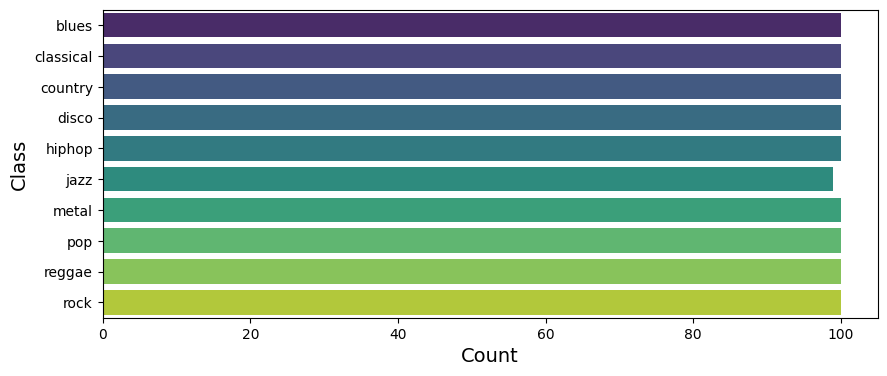

In [26]:
plt.figure(figsize = (10, 4))
sns.countplot(y = data['Class'], palette = 'viridis')
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

In [27]:
# Alignment feature number
x = data['Features'].tolist()
x = pad_sequences(x, dtype = 'float32', padding = 'post', truncating = 'post')
x.shape

(999, 43, 128)

#### Label encoder target variable

In [28]:
# Encode the label data to int
encoder = LabelEncoder()
y = data['Class']

y = encoder.fit_transform(y)
y = to_categorical(y)

#### Split data into traing and teating set

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

In [30]:
print(x_train.shape)
print(y_train.shape)

(749, 43, 128)
(749, 10)


### 3.1 Data for other models (From csv files)

In [31]:
csv_data = pd.read_csv('archive/Data/features_30_sec.csv')
csv_data = csv_data.iloc[0:,2:]
csv_data.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [32]:
x2 = csv_data.loc[:, csv_data.columns != 'label']
y2 = csv_data['label']

# Normalize the data
cols = x2.columns
scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(x2)
x2 = pd.DataFrame(scaled, columns=cols)

In [33]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.3,random_state=2)

## Part 4: Modeling

### 4.1 Model building

#### CNN

In [34]:
def CNN():
    Cnn = Sequential()
    
    # First convolutional layer with batch normalization
    Cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(43,128,1)))
    Cnn.add(BatchNormalization())
    Cnn.add(Activation('relu'))
    Cnn.add(MaxPooling2D((2, 2)))
    Cnn.add(Dropout(0.2))

    # Second convolutional layer with batch normalization
    Cnn.add(Conv2D(64, (3, 3), padding='same'))
    Cnn.add(BatchNormalization())
    Cnn.add(Activation('relu'))
    Cnn.add(MaxPooling2D((2, 2)))
    Cnn.add(Dropout(0.3))

    # Third convolutional layer with batch normalization
    Cnn.add(Conv2D(128, (3, 3), padding='same'))
    Cnn.add(BatchNormalization())
    Cnn.add(Activation('relu'))
    Cnn.add(MaxPooling2D((2, 2)))
    Cnn.add(Dropout(0.4))

    # Flatten and fully connected layer with batch normalization
    Cnn.add(Flatten())
    Cnn.add(Dense(128))
    Cnn.add(BatchNormalization())
    Cnn.add(Activation('relu'))
    Cnn.add(Dropout(0.5))

    # Output layer with softmax activation
    Cnn.add(Dense(10, activation='softmax'))

    return Cnn
Cnn = CNN()

Cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 128, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 43, 128, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 43, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 21, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 64, 64)        1

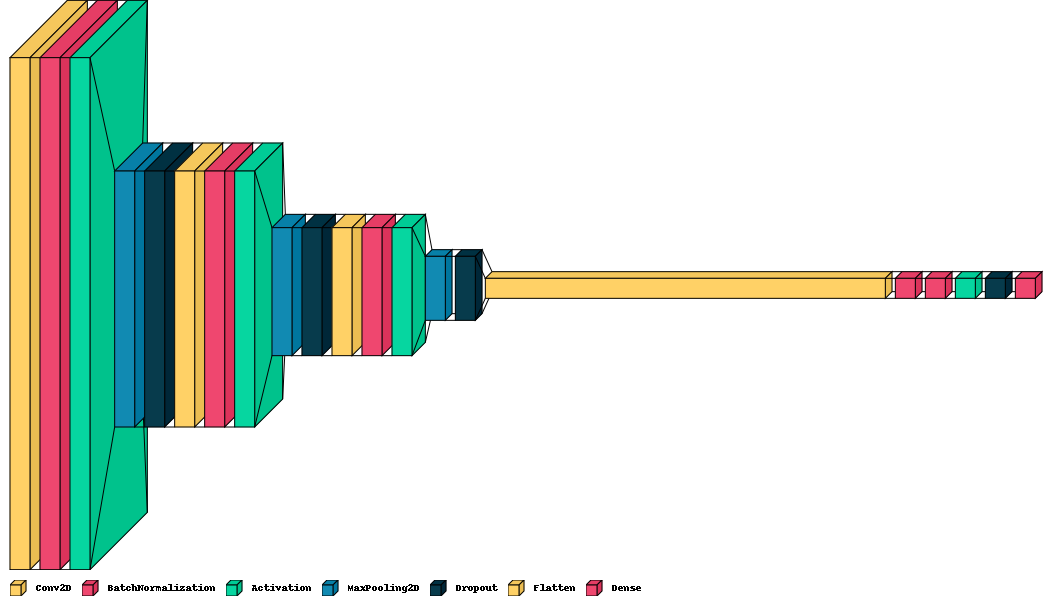

In [35]:
layered_view(Cnn, legend = True)

#### CNN evaluation

In [36]:
"""
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    min_delta = 0.001,
    restore_best_weights = True
)
"""

"\nearlyStopping = EarlyStopping(\n    monitor = 'val_accuracy',\n    patience = 10,\n    min_delta = 0.001,\n    restore_best_weights = True\n)\n"

In [37]:
history = Cnn.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 40,
    # callbacks = [earlyStopping]
)

Epoch 1/40



24/24 [==============================] - 3s 66ms/step - loss: 1.8779 - accuracy: 0.3792 - val_loss: 2.3230 - val_accuracy: 0.1760
Epoch 2/40
24/24 [==============================] - 1s 58ms/step - loss: 1.0851 - accuracy: 0.6502 - val_loss: 3.1219 - val_accuracy: 0.1200
Epoch 3/40
24/24 [==============================] - 1s 57ms/step - loss: 0.9039 - accuracy: 0.7036 - val_loss: 4.1152 - val_accuracy: 0.1200
Epoch 4/40
24/24 [==============================] - 1s 57ms/step - loss: 0.8060 - accuracy: 0.7423 - val_loss: 4.6098 - val_accuracy: 0.1200
Epoch 5/40
24/24 [==============================] - 1s 57ms/step - loss: 0.7543 - accuracy: 0.7423 - val_loss: 5.0992 - val_accuracy: 0.1200
Epoch 6/40
24/24 [==============================] - 1s 58ms/step - loss: 0.6874 - accuracy: 0.7864 - val_loss: 5.3215 - val_accuracy: 0.1200
Epoch 7/40
24/24 [==============================] - 2s 63ms/step - loss: 0.6119 - accuracy: 0.7997 - val_loss: 5.6184 - val_accuracy: 0.1200
Epoch 8/40
24/24 [======

<Axes: >

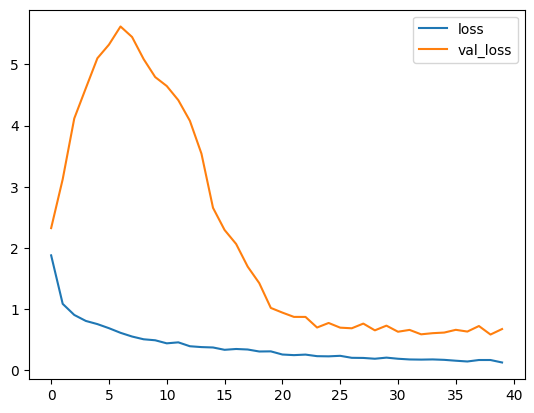

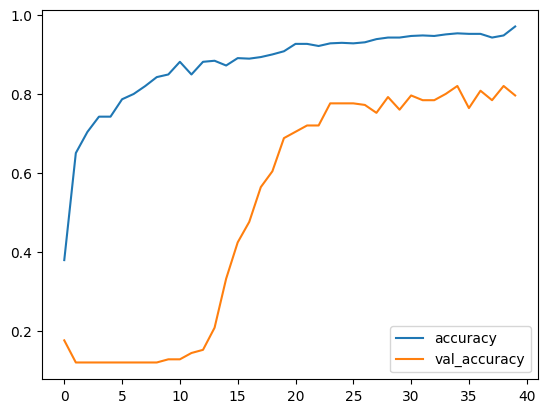

In [38]:
historyData = pd.DataFrame(history.history)
historyData.loc[:,['loss', 'val_loss']].plot()
historyData.loc[:, ['accuracy', 'val_accuracy']].plot()

#### Other models

In [39]:
# Decision trees
Tree = DecisionTreeClassifier()

# Random Forest
Rf = RandomForestClassifier()

# Logistic Regression
Lr = LogisticRegression()

In [40]:
def model_evaluation(model, title):
    model.fit(x_train2, y_train2)
    preds = model.predict(x_test2)
    print(confusion_matrix(y_test2, preds))
    print('Accuracy for', title, ':', round(accuracy_score(y_test2, preds), 5), '\n')

Models = [Tree, Rf, Lr]
for model in Models:
    model_evaluation(model, str(model))

[[11  0  6  2  0  2  0  0  1  2]
 [ 0 26  1  0  0  5  0  0  0  0]
 [ 4  2 12  3  0  9  0  2  1  1]
 [ 3  0  0  9  6  1  2  0  4  5]
 [ 0  0  2  5  9  0  1  4  8  0]
 [ 0  2  1  2  2 18  0  2  0  2]
 [ 3  0  1  1  4  1 17  0  1  2]
 [ 0  0  1  4  1  0  0 12  5  3]
 [ 1  0  0  4  2  1  1  3 18  7]
 [ 6  0  4  2  0  4  1  3  3  6]]
Accuracy for DecisionTreeClassifier() : 0.46 

[[16  0  4  1  0  1  0  0  1  1]
 [ 0 27  0  0  0  5  0  0  0  0]
 [ 1  0 26  0  0  3  0  1  0  3]
 [ 0  1  0 18  3  0  1  3  2  2]
 [ 3  0  0  0 15  0  1  5  5  0]
 [ 1  0  1  0  0 26  0  1  0  0]
 [ 0  0  0  1  1  0 24  0  0  4]
 [ 0  0  0  2  0  2  0 22  0  0]
 [ 1  2  3  0  1  0  0  2 25  3]
 [ 3  0  3  5  0  2  1  2  1 12]]
Accuracy for RandomForestClassifier() : 0.70333 

[[14  0  2  1  0  3  2  0  0  2]
 [ 0 30  0  0  0  2  0  0  0  0]
 [ 2  1 20  2  0  2  0  4  0  3]
 [ 0  1  0 14  3  1  4  3  1  3]
 [ 2  0  0  0 16  0  3  2  6  0]
 [ 2  0  1  0  0 25  0  1  0  0]
 [ 1  0  0  1  2  0 24  0  0  2]
 [ 0  0  0

d:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Part 5: Tune models

#### Grid search